# Landing Performance

The following is taken from U.S. Naval Test Pilot School. ‘USNTPS Fixed Wing Performance (USNTPS-FTM-NO. 108)’. In U.S. Naval Test Pilot School Flight Test Manual, 1992.

## Required Equations

1. Wind velocity component along the runway:
$$
V_w = \text{Wind Velocity} \cdot \cos(\text{Wind Direction Relative To Runway})
$$

2. Effective touchdown airspeed with wind:
$$
V_{\text{TD}_w} = V_{\text{TD}} - V_w
$$

3. Standard landing distance corrected for wind:
$$
S_{4_{\text{Std}}} = S_{4_w} \left(1 + \frac{V_w}{V_{\text{TD}}}\right)^{1.85}
$$

4. Standard landing distance corrected for slope:
$$
S_{4_{\text{Std}}} = \frac{S_{4_{\text{SL}}}}{\left(1 - \frac{2g \, S_{4_{\text{SL}}} \sin \theta}{V_{\text{TD}}^2}\right)}
$$

5. Density ratio:
$$
\sigma = 9.625 \frac{P_a}{T_a}
$$

6. Standard landing distance corrected for weight and density:
$$
S_{4_{\text{Std}}} = S_{4_{\text{Test}}} \left(\frac{W_{\text{Std}}}{W_{\text{Test}}}\right)^2 \left(\frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}}\right)
$$

7. Energy height $ E_h $ representing the kinetic energy change during the air phase:
$$
E_h = \frac{V_{50}^2 - V_{\text{TD}}^2}{2g}
$$

8. Standard air distance corrected for weight, energy height, and density:
$$
S_{3_{\text{Std}}} = S_{3_{\text{Test}}} \left( \frac{W_{\text{Std}}}{W_{\text{Test}}} \right)^{2 + \frac{E_h}{E_h + 50}} \left( \frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}} \right)^{\frac{E_h}{E_h + 50}}
$$


### Variables
- $ g $: Gravitational acceleration ($ft/s$^2$)
- $ P_a $: Ambient pressure (psf)
- $ \theta $: Runway slope angle (deg)
- $ S_{4_{\text{SL}}} $: Landing distance, touchdown to stop, sloping runway (ft)
- $ S_{4_{\text{Std}}} $: Standard landing distance, touchdown to stop (ft)
- $ S_{4_{\text{Test}}} $: Test landing distance, touchdown to stop (ft)
- $ S_{4_w} $: Landing distance, touchdown to stop, with respect to wind (ft)
- $ \sigma_{\text{Std}} $: Standard density ratio
- $ \sigma_{\text{Test}} $: Test density ratio
- $ T_a $: Ambient temperature (°K)
- $ V_{\text{TD}} $: Touchdown ground speed (ft/s)
- $ V_{\text{TD}_w} $: Touchdown ground speed with respect to wind (ft/s)
- $ V_w $: Wind velocity (ft/s)
- $ W_{\text{Std}} $: Standard weight (lb)
- $ W_{\text{Test}} $: Test weight (lb)
- $ E_h $: Energy Height (ft)
- $ V_{50} $: Ground speed at 50 ft reference point (ft/s)
- $ V_{\text{TD}} $: Touchdown ground speed (ft/s)


## Pilot's Data

1. Ground roll distance (touchdown to full stop) (ft).
2. Wind velocity and direction relative to the runway (ft/s / degrees).
3. Touchdown airspeed $ V_{\text{TD}} $ (corrected for position and instrument error) (ft/s).
4. Temperature $ T_a $ (°K).
5. Aircraft weight $ W $ (lb).
6. Pressure altitude $ H_p $ (ft).
7. Runway slope $ \theta $ (deg).

## Order of Analysis

| Step | Parameter               | Notation                                                                                                                   | Formula   | Units | Remarks                   |
|------|--------------------------|----------------------------------------------------------------------------------------------------------------------------|-----------|-------|---------------------------|
| 1    | Wind component           | $ V_w $                                                                                                                  | Eq 9.38   | ft/s  |                           |
| 2    | Touchdown ground speed   | $ V_{\text{TD}} $                                                                                                        | Eq 9.40   | ft/s  |                           |
| 3    | Ground roll              | $ S_{4_{\text{Std}}} $                                                                                                   | Eq 9.41   | ft    | Wind corrected            |
| 4    | Ground roll              | $ S_{4_{\text{Std}}} $                                                                                                   | Eq 9.42   | ft    | Slope corrected           |
| 5    | Density ratio            | $ \sigma $                                                                                                               | Eq 9.39   |       |                           |
| 6    | Ground roll              | $ S_{4_{\text{Std}}} $                                                                                                   | Eq 9.37   | ft    | Weight, density corrected |
| 7    | Energy Height            | $ E_h $                                                                          |  Eq 9.36     | ft    |                           |
| 8    | Air Distance             | $ S_{3_{\text{Std}}} $ | Eq. 9.35     | ft    | Wind Corrected            |


## Python Code

In [509]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from atmosphere import Atmosphere

atm = Atmosphere()

# Constants
g = 32.17  # ft/s^2

### Functions

#### Wind Component
$$
V_w = \text{Wind Velocity} \cdot \cos(\text{Wind Direction Relative To Runway})
$$

In [510]:
# Step 1
def headwind_component(v, relative_angle):
    component = v * np.cos(np.radians(relative_angle))
    # If the result is very close to zero, set it to zero, due floating point errors
    tolerance = 1e-10
    if abs(component) < tolerance:
        return 0.0
    return component

#### Touchdown Groundspeed
$$
V_{\text{TD}_w} = V_{\text{TD}} - V_w
$$

In [511]:
# Step 2
def touchdown_groundspeed(v_td, v_w):
    return v_td - v_w

#### Standard landing distance corrected for wind
$$
S_{4_{\text{Std}}} = S_{4_w} \left(1 + \frac{V_w}{V_{\text{TD}}}\right)^{1.85}
$$


In [512]:
# Step 3
def wind_corrected_ground_roll(s_4w, v_w, v_td):
    return s_4w * (1 + v_w / v_td) ** 1.85

#### Standard landing distance corrected for slope:
$$
S_{4_{\text{Std}}} = \frac{S_{4_{\text{SL}}}}{\left(1 - \frac{2g \, S_{4_{\text{SL}}} \sin \theta}{V_{\text{TD}}^2}\right)}
$$

In [513]:
# Step 4
def slope_corrected_ground_roll(s4_sl, v_td, theta):
    return s4_sl / (1 - (2 * g * s4_sl * np.sin(np.radians(theta))) / (v_td**2))

#### Density ratio:
$$
\sigma = 9.625 \frac{P_a}{T_a}
$$

In [514]:
# Step 5
def density_ratio(p_a, p_t):
    return 9.625 * (p_a / p_t)

#### Standard landing distance corrected for weight and density:
$$
S_{4_{\text{Std}}} = S_{4_{\text{Test}}} \left(\frac{W_{\text{Std}}}{W_{\text{Test}}}\right)^2 \left(\frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}}\right)
$$

In [515]:
# Step 6
def weight_density_corrected_ground_roll(s4_test, w_std, w_test, sigma_test, sigma_std):
    return s4_test * (w_std / w_test) ** 2 * (sigma_test / sigma_std)

#### Energy height $ E_h $ representing the kinetic energy change during the air phase:
$$
E_h = \frac{V_{50}^2 - V_{\text{TD}}^2}{2g}
$$

In [516]:
def energy_height(v_50, v_td):
    return (v_50**2 - v_td**2) / (2 * g)

#### Standard air distance corrected for weight, energy height, and density:
$$
S_{3_{\text{Std}}} = S_{3_{\text{Test}}} \left( \frac{W_{\text{Std}}}{W_{\text{Test}}} \right)^{2 + \frac{E_h}{E_h + 50}} \left( \frac{\sigma_{\text{Test}}}{\sigma_{\text{Std}}} \right)^{\frac{E_h}{E_h + 50}}
$$

In [517]:
def weight_energy_density_corrected_air_distance(
    s3_test, w_std, w_test, e_h, sigma_test, sigma_std
):
    return (
        s3_test
        * (w_std / w_test) ** (2 + e_h / (e_h + 50))
        * (sigma_test / sigma_std) ** (e_h / (e_h + 50))
    )

### Additional Functions

#### Haversine Distance
For calculating the great circle distance between two latitude and longitudes

In [518]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in meters
    R = 6371000

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in meters
    distance_meters = R * c

    # Convert distance from meters to feet
    distance_feet = distance_meters * 3.28084

    return distance_feet

### Load Data

In [519]:
# df_landing = pd.read_excel("demo_data/landing.xlsx")
df_landing2 = pd.read_csv(
    "./data/csv/6Nov24-flight2-landing.csv", parse_dates=["timestamp"]
)
df_landing3 = pd.read_csv(
    "./data/csv/6Nov24-flight3-landing.csv", parse_dates=["timestamp"]
)
df_landing4 = pd.read_csv(
    "./data/csv/6Nov24-flight4-landing.csv", parse_dates=["timestamp"]
)
df_landing5 = pd.read_csv(
    "./data/csv/7Nov24-flight5-landing.csv", parse_dates=["timestamp"]
)

df_landing2_ft = pd.read_excel("./data/landings.xlsx", sheet_name="flight2")
df_landing3_ft = pd.read_excel("./data/landings.xlsx", sheet_name="flight3")
df_landing4_ft = pd.read_excel("./data/landings.xlsx", sheet_name="flight4")
df_landing5_ft = pd.read_excel("./data/landings.xlsx", sheet_name="flight5")

df_landings = [df_landing2, df_landing3, df_landing4, df_landing5]
df_landings_ft = [df_landing2_ft, df_landing3_ft, df_landing4_ft, df_landing5_ft]

### Data Reduction

In [520]:
def calculate_landing_data(df_landing, df_landing_ft):
    ias_at_50 = df_landing_ft.loc[0, "50ft_kts"]
    ias_at_50_fps = atm.kts_to_fps(ias_at_50)
    lat_at_50 = df_landing.loc[0, "latitude"]
    lon_at_50 = df_landing.loc[0, "longitude"]
    time_at_50 = df_landing.loc[0, "timestamp"]

    seconds_at_touchdown = df_landing_ft.loc[0, "touchdown_seconds"]
    time_at_touchdown = time_at_50 + pd.Timedelta(seconds=seconds_at_touchdown)
    index_at_touchdown = df_landing["timestamp"].sub(time_at_touchdown).abs().idxmin()
    seconds_at_stop = df_landing_ft.loc[0, "stop_seconds"]
    time_at_stop = time_at_touchdown + pd.Timedelta(seconds=seconds_at_stop)
    index_at_stop = df_landing["timestamp"].sub(time_at_stop).abs().idxmin()

    lat_at_td = df_landing.loc[index_at_touchdown, "latitude"]
    lon_at_td = df_landing.loc[index_at_touchdown, "longitude"]
    ias_at_td = df_landing_ft.loc[0, "touchdown_kts"]
    ias_at_td_fps = atm.kts_to_fps(ias_at_td)

    lat_at_stop = df_landing.loc[index_at_stop, "latitude"]
    lon_at_stop = df_landing.loc[index_at_stop, "longitude"]

    ground_roll = haversine_distance(lat_at_td, lon_at_td, lat_at_stop, lon_at_stop)
    air_distance = haversine_distance(lat_at_50, lon_at_50, lat_at_td, lon_at_td)

    return {
        "ground_roll": ground_roll,
        "air_distance": air_distance,
        "ias_at_td_fps": ias_at_td_fps,
        "ias_at_50_fps": ias_at_50_fps,
        "rwy": df_landing_ft.loc[0, "rwy"],
        "slope": df_landing_ft.loc[0, "slope"],
        "oat": df_landing_ft.loc[0, "oat"],
        "pressure_alt": df_landing_ft.loc[0, "theshold_alt"],
        "wind_dir": df_landing_ft.loc[0, "wind_dir"],
        "wind_vel_kts": df_landing_ft.loc[0, "wind_vel_kts"],
    }

### Test Parameters

In [521]:
# Aircraft Data
BW = 8620  # lbs
crew = 196 + 180  # lbs
ZFW = BW + crew  # lbs
fuel = 2000  # lbs
w_t = ZFW + fuel  # lbs
w_s = 10500  # lbs

# Customer Requirements
cr_landing_distance = 4000  # feet
confidence = 0.95

### Data Analysis

In [522]:
def standardise_landing(landing_test_data):
    wind_vel_kts = landing_test_data["wind_vel_kts"]
    wind_speed_fps = atm.kts_to_fps(landing_test_data["wind_vel_kts"])
    wind_dir = landing_test_data["wind_dir"]
    rwy = landing_test_data["rwy"]
    rwy_dir = rwy * 10
    # Calculate the absolute difference between the two angles
    angle_diff = abs(rwy_dir - wind_dir)
    # Adjust for angles that cross 360 degrees
    wind_relative_angle = min(angle_diff, 360 - angle_diff)
    ground_roll = landing_test_data["ground_roll"]
    ias_at_td_fps = landing_test_data["ias_at_td_fps"]
    ias_at_50_fps = landing_test_data["ias_at_50_fps"]
    slope = landing_test_data["slope"]
    elevation = landing_test_data["pressure_alt"]
    air_distance = landing_test_data["air_distance"]

    headwind = headwind_component(wind_speed_fps, wind_relative_angle)
    # TODO: why isn't td_groundspeed not used?
    td_groundspeed = touchdown_groundspeed(ias_at_td_fps, headwind)
    wind_corrected_ground_roll_distance = wind_corrected_ground_roll(
        ground_roll, headwind, ias_at_td_fps
    )
    print("wind_corrected_ground_roll_distance", wind_corrected_ground_roll_distance)
    slope_corrected_ground_roll_distance = slope_corrected_ground_roll(
        wind_corrected_ground_roll_distance, ias_at_td_fps, slope
    )
    print("Slope correction", slope_corrected_ground_roll_distance)
    sigma_t = atm.get_std_sigma(elevation)
    sigma_s = atm.get_std_sigma(elevation)
    w_d_corrected_ground_roll_distance = weight_density_corrected_ground_roll(
        slope_corrected_ground_roll_distance, w_s, w_t, sigma_t, sigma_s
    )
    print("Weight density corrected ground roll", w_d_corrected_ground_roll_distance)
    # TODO: why isn't v_w_50 not used?
    v_w_50 = touchdown_groundspeed(ias_at_50_fps, headwind)
    energy_height_value = energy_height(ias_at_50_fps, ias_at_td_fps)
    w_e_d_corrected_air_distance = weight_energy_density_corrected_air_distance(
        air_distance, w_s, w_t, energy_height_value, sigma_t, sigma_s
    )

    return {
        "standardised_ground_roll": w_d_corrected_ground_roll_distance,
        "standardised_air_distance": w_e_d_corrected_air_distance,
    }


landing_data = []
for i in range(len(df_landings)):
    test_data = calculate_landing_data(df_landings[i], df_landings_ft[i])
    standardised = standardise_landing(test_data)
    landing_data.append(
        {
            "ground_roll": test_data["ground_roll"],
            "air_distance": test_data["air_distance"],
            "standardised_ground_roll": standardised["standardised_ground_roll"],
            "standardised_air_distance": standardised["standardised_air_distance"],
        }
    )

print(landing_data)

wind_corrected_ground_roll_distance 3282.0233516236603
Slope correction 3282.0233516236603
Weight density corrected ground roll 2992.614683692881
wind_corrected_ground_roll_distance 2701.9768652211424
Slope correction 2701.9768652211424
Weight density corrected ground roll 2463.7166697363723
wind_corrected_ground_roll_distance 2770.2514205204548
Slope correction 2770.2514205204548
Weight density corrected ground roll 2525.9707778950615
wind_corrected_ground_roll_distance 2586.633910134592
Slope correction 2586.633910134592
Weight density corrected ground roll 2358.5446511150617
[{'ground_roll': 2271.795498020905, 'air_distance': 1759.7209062830993, 'standardised_ground_roll': 2992.614683692881, 'standardised_air_distance': 1574.848439484225}, {'ground_roll': 2519.906075484418, 'air_distance': 1445.2020512638253, 'standardised_ground_roll': 2463.7166697363723, 'standardised_air_distance': 1278.9338246262948}, {'ground_roll': 2220.2845491343423, 'air_distance': 1434.500755288164, 'standa

#### Plot

[4567.46312318 3742.65049436 3806.60555371 3350.42347904]
Mean landing distance (over 50 ft): 3866.79 ft +/- 809.60 ft
95% confidence interval: (3057.18, 4676.39) ft


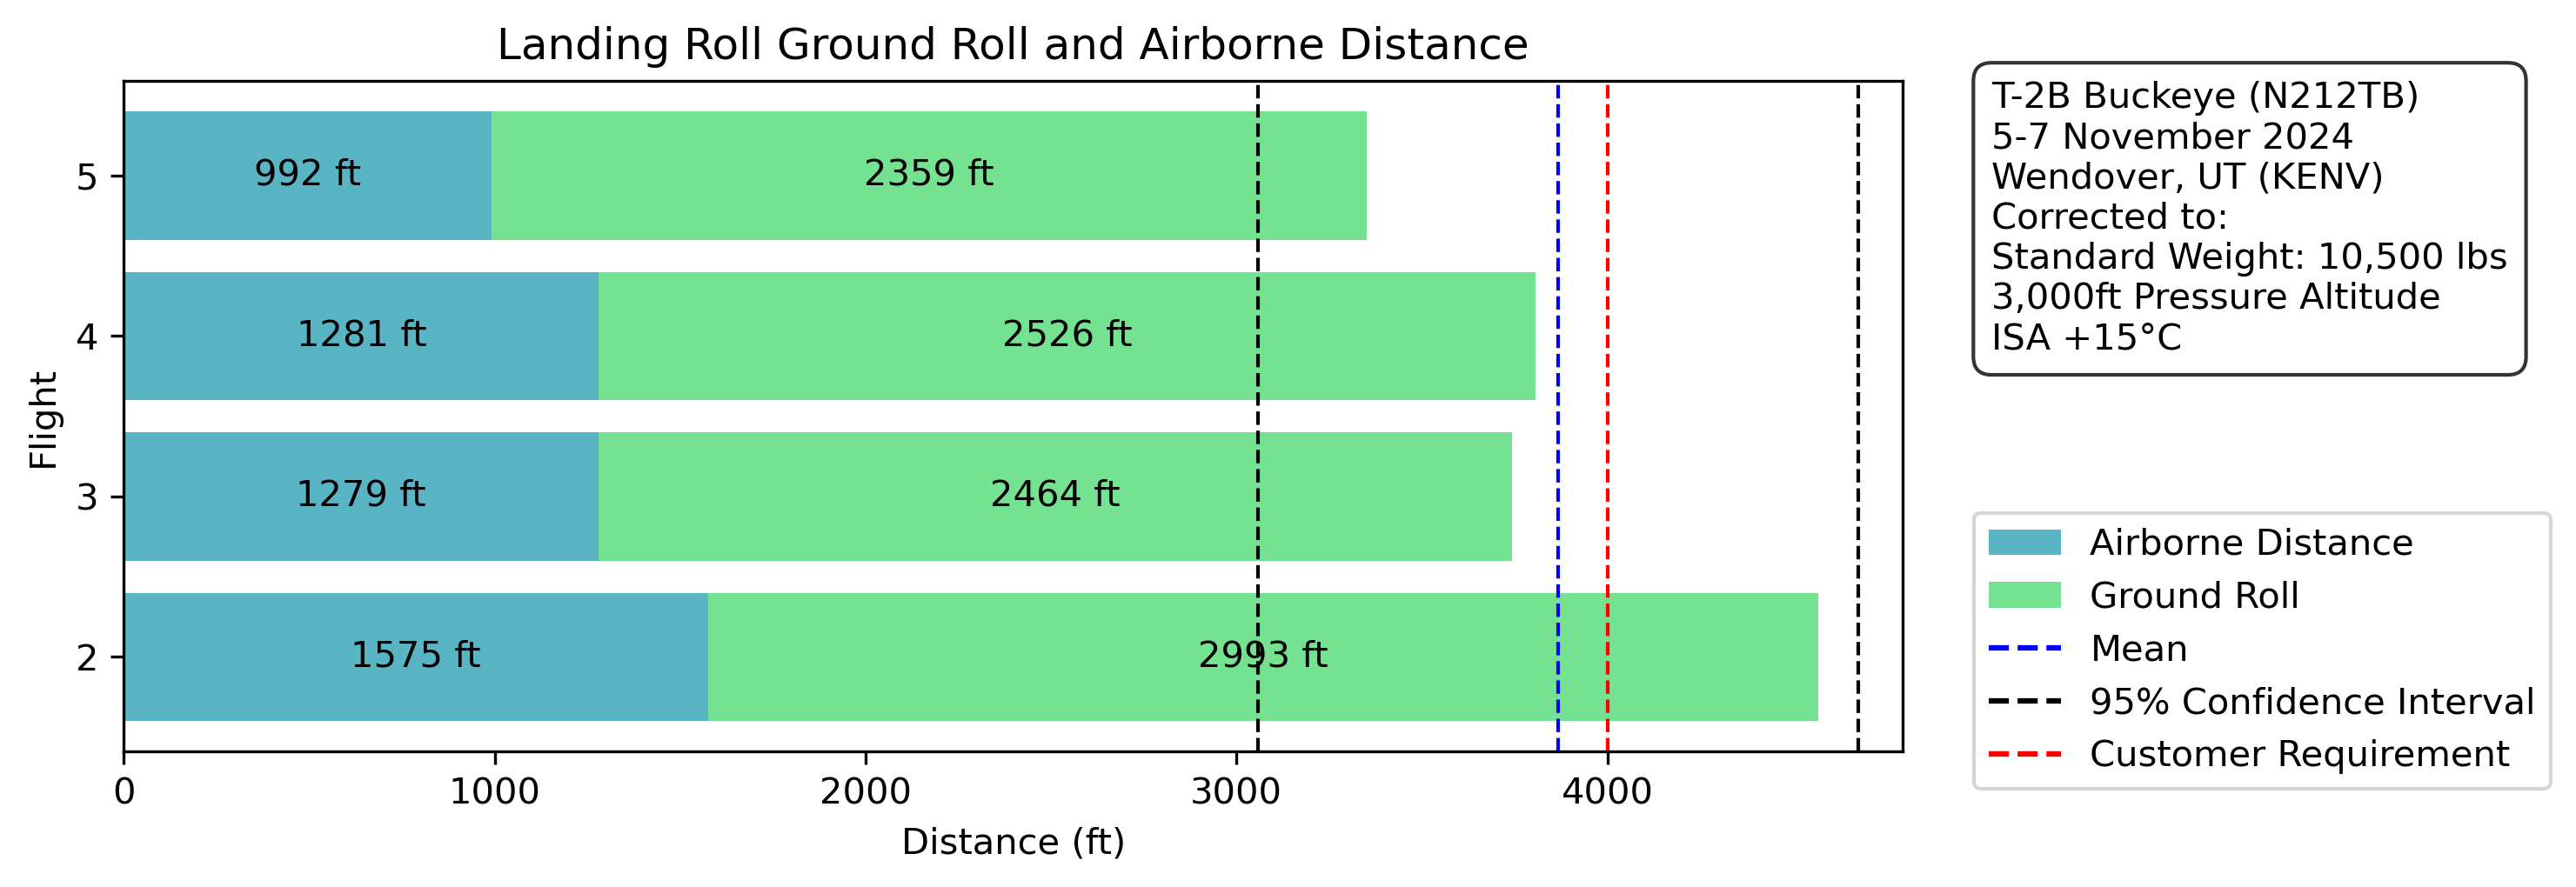

In [523]:
plt.figure(figsize=(10, 3.5), dpi=300)

ground_rolls = np.array([entry["standardised_ground_roll"] for entry in landing_data])
airborne_distances = np.array(
    [entry["standardised_air_distance"] for entry in landing_data]
)

airborne_distance_color = "#59B4C3"
ground_roll_color = "#74E291"

bar_airborne_distance = plt.barh(
    range(2, len(airborne_distances) + 2),
    airborne_distances,
    color=airborne_distance_color,
    label="Airborne Distance",
)

bar_ground_roll = plt.barh(
    range(2, len(ground_rolls) + 2),
    ground_rolls,
    left=airborne_distances,
    color=ground_roll_color,
    label="Ground Roll",
)

for i, (ad, gr) in enumerate(zip(airborne_distances, ground_rolls), start=1):
    plt.text(ad / 2, i + 1, f"{ad:.0f} ft", ha="center", va="center", color="black")
    plt.text(
        gr / 2 + ad, i + 1, f"{gr:.0f} ft", ha="center", va="center", color="black"
    )

# Confidence intervals
# Get 95% confidence interval
total_distance = airborne_distances + ground_rolls
print(total_distance)
# Calculate the mean
mean = np.mean(total_distance)
# Calculate the standard error of the mean
sem = stats.sem(total_distance)

# Calculate the degrees of freedom (aka Alpha)
n = len(total_distance)
df = n - 1

t_critical = stats.t.ppf((1 + confidence) / 2, df)
margin_of_error = t_critical * sem
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print(f"Mean landing distance (over 50 ft): {mean:.2f} ft +/- {margin_of_error:.2f} ft")
print(
    f"95% confidence interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) ft"
)

plt.axvline(x=mean, color="blue", linestyle="--", linewidth=1)
plt.axvline(x=confidence_interval[0], color="black", linestyle="--", linewidth=1)
plt.axvline(x=confidence_interval[1], color="black", linestyle="--", linewidth=1)
# Add vertical red line at 4000 ft
plt.axvline(x=cr_landing_distance, color="red", linestyle="--", linewidth=1)

# Define proxy artists for the custom lines
mean_line = mlines.Line2D([], [], color="blue", linestyle="--", label="Mean")
confidence_interval_line = mlines.Line2D(
    [], [], color="black", linestyle="--", label="95% Confidence Interval"
)
requirement_line = mlines.Line2D(
    [], [], color="red", linestyle="--", label="Customer Requirement"
)

details = (
    "T-2B Buckeye (N212TB)\n"
    "5-7 November 2024\n"
    "Wendover, UT (KENV)\n"
    "Corrected to:\n"
    "Standard Weight: 10,500 lbs\n"
    "3,000ft Pressure Altitude\n"
    "ISA +15°C"
)
# Add the textbox
props = dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
plt.gca().text(
    1.05,
    1,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=props,
)

plt.xlabel("Distance (ft)")
plt.gca().set_yticks(range(2, len(ground_rolls) + 2))
plt.ylabel("Flight")
plt.title("Landing Roll Ground Roll and Airborne Distance")
plt.legend(loc="center left", bbox_to_anchor=(1.03, 0.15))
plt.legend(
    handles=[
        bar_airborne_distance,
        bar_ground_roll,
        mean_line,
        confidence_interval_line,
        requirement_line,
    ],
    loc="center left",
    bbox_to_anchor=(1.03, 0.15),
)
# Show plot
plt.tight_layout()

# Save the plot
plt.savefig("./plots/landing_perf.png")

plt.show()